In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import random
random.seed(371)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
%matplotlib inline

/kaggle/input/classifying-customers-into-segments/sample_submission.csv
/kaggle/input/classifying-customers-into-segments/Train.csv
/kaggle/input/classifying-customers-into-segments/Test.csv


The objective of this project is to implement the K-means clustering algorithm manually and compare it with the K-means implementation in the Sklearn library. The project will begin with exploratory data analysis (EDA) and data preprocessing to ensure that the data is in a suitable format for clustering.

After preprocessing, the K-means algorithm will be implemented from scratch, initializing the centroids, assigning data points to clusters, and updating the centroids iteratively until convergence.

Next, I will compare the clustering centroids results obtained using the sklearn implementation of KMeans with the results obtained using a manually implemented version of KMeans, where I use the same initial centroids for both implementations.

The comparison of the resulting centroids will involve computing the Euclidean distance between each pair of centroids obtained from both implementations. If the centroids obtained from both implementations are similar, we should expect the distance between them to be small.

Overall, this project aims to provide a comprehensive understanding of the K-means algorithm and its implementation from scratch, as well as its performance compared to the Sklearn implementation. 

# Data EDA

In [2]:
# Import train and test data

train_df = pd.read_csv('/kaggle/input/classifying-customers-into-segments/Train.csv')
test_df = pd.read_csv('/kaggle/input/classifying-customers-into-segments/Test.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [4]:
train_df.nunique()

ID                 8068
Gender                2
Ever_Married          2
Age                  67
Graduated             2
Profession            9
Work_Experience      15
Spending_Score        3
Family_Size           9
Var_1                 7
Segmentation          4
dtype: int64

Given that the 'ID' column contains 8068 unique values, which does not provide any useful information, we will remove it from both the train_df and test_df data frames. Additionally, as we intend to implement Kmeans, we will drop the 'Segmentation' column from train_df. Furthermore, since there are only 4 unique values in the 'Segmentation' column, we will set k = 4 for Kmeans.

In [5]:
# Drop ID column
train_df = train_df.drop(['ID', 'Segmentation'], axis = 1)
test_df = test_df.drop('ID', axis = 1)

Since we intend to utilize Kmeans, we will concatenate the train_df and test_df data frames.

In [6]:
combined_df = pd.concat([train_df, test_df], axis = 0)

In [7]:
print(combined_df.shape)
combined_df.isna().sum()

(10695, 9)


Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
dtype: int64

We will first examine the proportion of categorical values using a pie chart and analyze numerical values using a histogram, before proceeding to impute any missing values.

In [8]:
categorical_columns = [col for col in combined_df.columns if combined_df[col].dtypes == 'object']
numerical_columns = [col for col in combined_df.columns if combined_df[col].dtypes != 'object']

In [9]:
print('numerical_col: ', numerical_columns)
print('categorical_col: ', categorical_columns)

numerical_col:  ['Age', 'Work_Experience', 'Family_Size']
categorical_col:  ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']


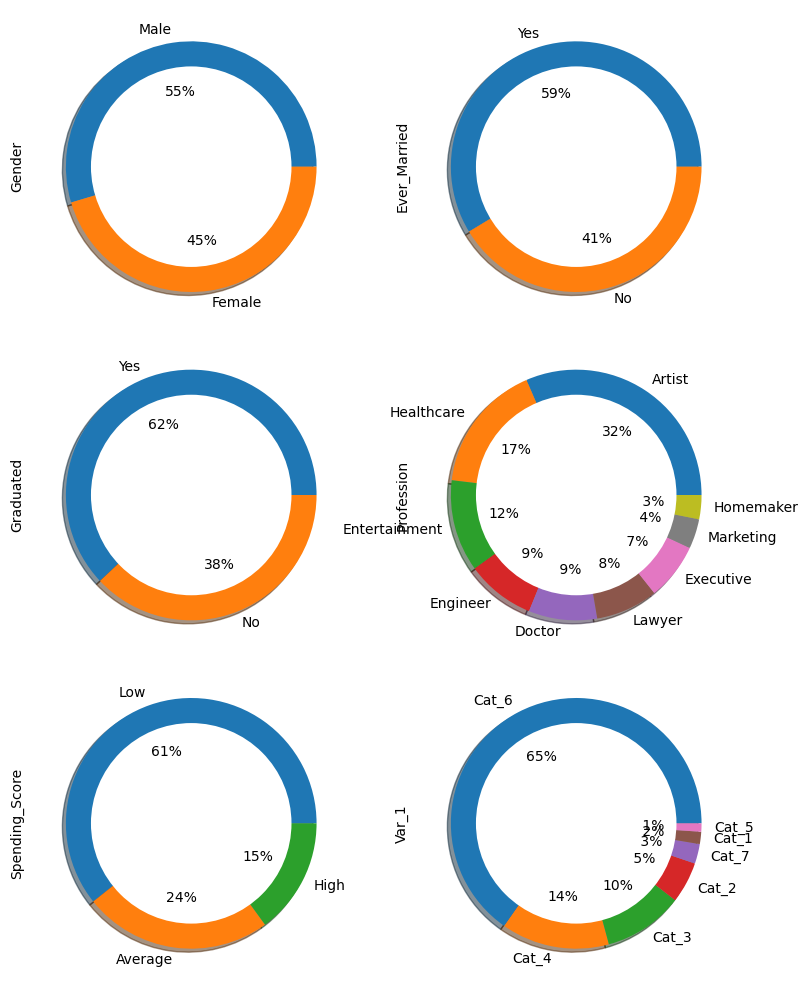

In [10]:
plt.figure(figsize = (8, 10))
for i, col in enumerate(categorical_columns):
    plt.subplot(3, 2, i+1)
    combined_df[col].value_counts().plot(kind = 'pie', autopct = '%2.f%%', shadow = True)
    centre_circle = plt.Circle((0, 0), 0.80, fc = 'white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
plt.tight_layout()
plt.show()

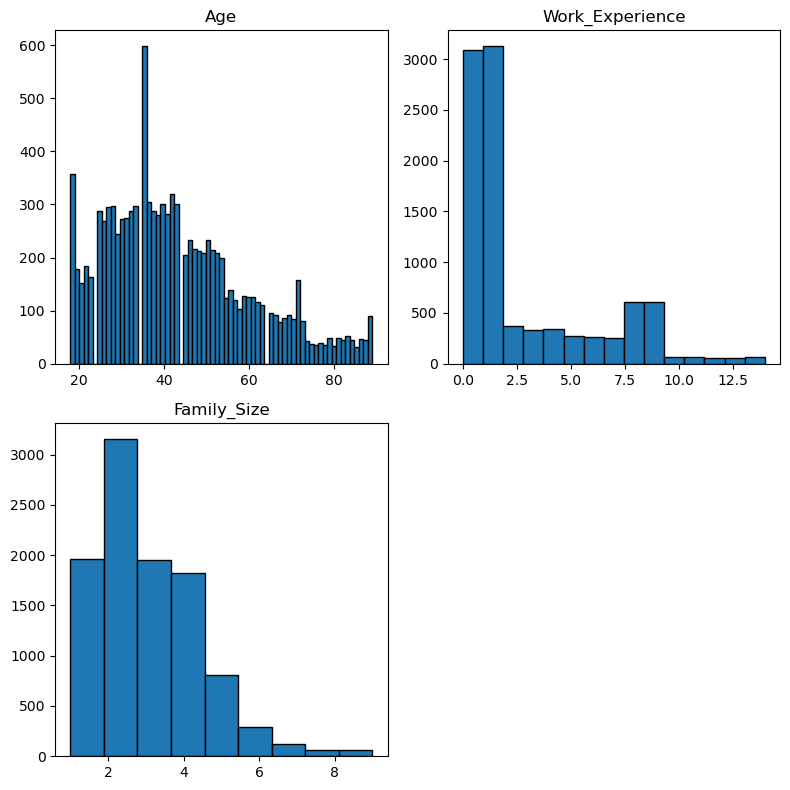

In [11]:
plt.figure(figsize = (8, 8))
for i, col in enumerate(numerical_columns):
    plt.subplot(2, 2, i+1)
    plt.hist(combined_df[col], bins = combined_df[col].nunique(), edgecolor = 'black')
    plt.title(col)
plt.tight_layout()
plt.show()


We have a total of 10695 instances and 9 features in our data set, and to handle missing values, we will impute them with the most frequently appearing values.

In [12]:
most_freq_values = combined_df.mode().iloc[0]
combined_df.fillna(most_freq_values, inplace = True)

Since 'Spending_Score' is an ordinal variable, we need to create a dictionary that converts its categories into corresponding ordinal values. This dictionary will be used to modify combined_df

In [13]:
Spending_Score_mapping = {
    'Low': 1,
    'Average': 2,
    'High': 3
}

In [14]:
combined_df['Spending_Score'] = combined_df['Spending_Score'].map(Spending_Score_mapping)

To apply different transformations to the numerical and categorical features in a dataset, we will use the ColumnTransformer class from scikit-learn. Specifically, we will use OneHotEncoder to transform the categorical features, and StandardScaler to transform the numerical features.

In [15]:
# We already transformed Ordinal feauture
categorical_columns.remove('Spending_Score')

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop = 'first')

preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_transformer, numerical_columns),
        ('cat', cat_transformer, categorical_columns)
    ])
X_transformed = preprocessor.fit_transform(combined_df)
pd.DataFrame(X_transformed)

0         1         2    3    4    5    6    7    8    9    10  \
0     -1.282499 -0.447327  0.787219  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
1     -0.328606 -0.447327  0.126415  0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0   
2      1.400325 -0.447327 -1.195194  0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0   
3      1.400325 -0.755089 -0.534390  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
4     -0.209369 -0.447327  2.108828  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   
...         ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
10690 -0.865170  2.014771  0.787219  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
10691 -0.507461 -0.447327 -1.195194  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0   
10692  0.565669 -0.447327 -0.534390  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0   
10693  0.207959 -0.447327  1.448024  1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
10694 -0.030514  2.014771  0.126415  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   

        11   12   13   14   15   16   17   18   19  
0      0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
3      0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  
10690  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
10691  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
10692  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
10693  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
10694  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[10695 rows x 20 columns]

In [16]:
X_transformed = pd.DataFrame(X_transformed)
X_transformed['cluster'] = np.zeros(len(X_transformed))

In [17]:
X_transformed

0         1         2    3    4    5    6    7    8    9  ...  \
0     -1.282499 -0.447327  0.787219  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1     -0.328606 -0.447327  0.126415  0.0  1.0  1.0  0.0  1.0  0.0  0.0  ...   
2      1.400325 -0.447327 -1.195194  0.0  1.0  1.0  0.0  1.0  0.0  0.0  ...   
3      1.400325 -0.755089 -0.534390  1.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   
4     -0.209369 -0.447327  2.108828  0.0  1.0  1.0  0.0  0.0  1.0  0.0  ...   
...         ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
10690 -0.865170  2.014771  0.787219  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
10691 -0.507461 -0.447327 -1.195194  0.0  0.0  1.0  1.0  0.0  0.0  0.0  ...   
10692  0.565669 -0.447327 -0.534390  0.0  0.0  1.0  0.0  0.0  1.0  0.0  ...   
10693  0.207959 -0.447327  1.448024  1.0  1.0  1.0  0.0  0.0  0.0  1.0  ...   
10694 -0.030514  2.014771  0.126415  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   

        11   12   13   14   15   16   17   18   19  cluster  
0      0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0  
1      0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0  
3      0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0  
...    ...  ...  ...  ...  ...  ...  ...  ...  ...      ...  
10690  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0  
10691  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0  
10692  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0  
10693  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0  
10694  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0  

[10695 rows x 21 columns]

# Manually Implemented KMeans

In [18]:
def initiate_centroids(X):
    centroids = X.sample(4)
    return centroids

def euclidean_distance(a, b):
    return np.square(np.sum((a-b)**2))

def assign_cluster(centroid, X):
    for idx_data in range(len(X)):
        distance = []
        for i in range(4):
            distance.append(euclidean_distance(centroid.iloc[i], X.iloc[idx_data]))
        cent_distance = np.array(distance)
        cluster = np.argmin(cent_distance)
        X.loc[idx_data, 'cluster'] = cluster
    return X

def update_centroids(X):
    centroids = []
    for i in range(4):
        centroids.append(X[X.cluster == i].mean(axis = 0))
    return pd.DataFrame(centroids)

In [19]:
init_centroids = initiate_centroids(X_transformed)
X = assign_cluster(init_centroids,X_transformed)
centroids = update_centroids(X)
while(True):
    assign_cluster(centroids, X)
    updated_centroids = update_centroids(X)
    if euclidean_distance(centroids.values, updated_centroids.values) == 0:
        break
    centroids = updated_centroids

In [20]:
pd.DataFrame(updated_centroids)

0         1         2         3         4         5         6  \
0  0.678189 -0.512411 -0.354523  0.574958  0.869556  0.755653  0.067002   
1 -0.950395 -0.356934  0.238528  0.541120  0.134070  0.375605  0.124050   
2  0.008998 -0.122157  2.019264  0.565635  0.686233  0.508004  0.067236   
3 -0.238036  1.721601 -0.425838  0.478448  0.559866  0.718391  0.090038   

          7         8         9  ...        11        12        13        14  \
0  0.082705  0.118300  0.093593  ...  0.016960  0.157663  0.023869  0.033082   
1  0.077056  0.089150  0.020387  ...  0.016586  0.001037  0.059433  0.081548   
2  0.144077  0.117396  0.164354  ...  0.012807  0.035219  0.048026  0.075774   
3  0.087165  0.151820  0.055077  ...  0.089559  0.026341  0.034483  0.046935   

         15        16        17        18        19  cluster  
0  0.085427  0.098618  0.006281  0.740997  0.021985      0.0  
1  0.131306  0.175881  0.016586  0.542502  0.030408      1.0  
2  0.094984  0.312700  0.021345  0.448239  0.030950      2.0  
3  0.101533  0.096743  0.007663  0.713123  0.022510      3.0  

[4 rows x 21 columns]

# K-Means

In [26]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 4,
           init = init_centroids.iloc[:,:-1])
y_km = km.fit_predict(X_transformed.iloc[:,:-1].values)

/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [27]:
pd.DataFrame(km.cluster_centers_)

0         1         2         3         4         5         6   \
0  1.421093 -0.460945 -0.422484  0.606195  0.948512  0.709976  0.041030   
1 -0.412170 -0.460686 -0.494814  0.512637  0.483516  0.658242  0.111813   
2 -0.508808 -0.354498  1.345878  0.589774  0.473642  0.439556  0.093143   
3 -0.365991  1.816816 -0.265998  0.478983  0.508309  0.685239  0.090909   

         7         8         9         10        11        12        13  \
0  0.053500  0.093323  0.109413  0.007643  0.012068  0.319791  0.017699   
1  0.104670  0.134341  0.035165  0.171703  0.022527  0.004670  0.044505   
2  0.097503  0.102656  0.101467  0.318272  0.014269  0.005153  0.047959   
3  0.085533  0.131965  0.058162  0.148094  0.087977  0.009286  0.037146   

         14        15        16        17        18        19  
0  0.022526  0.059131  0.069187  0.003620  0.822607  0.013677  
1  0.047802  0.127198  0.145604  0.012912  0.616758  0.029670  
2  0.090369  0.111375  0.223543  0.013872  0.509314  0.032897  
3  0.051320  0.096774  0.102151  0.011241  0.705279  0.021505

In [28]:
euclidean_distance(updated_centroids.iloc[:,:-1].values, km.cluster_centers_)

7.220999366720627

In [29]:
euclidean_distance(init_centroids.iloc[:,:-1].values, km.cluster_centers_)

121.94331004644192